In [1]:
source("/secure/projects/HTAPP_MBC/src/init_phase2.R")
library("variancePartition")
library("gridExtra")
library("readxl")
library("sva")
library("AMR")
library("M3C")
library("pheatmap")

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Loading combined annotation: annot

Loading required package: limma

Loading required package: foreach

Loading required package: scales

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from 'package:limma':

    plotMA


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Ma

In [2]:
wd=paste0(analysisDir,"/02_explainVariability")
dir.create(wd)
setwd(wd)

Warning message in dir.create(wd):
"'/scratch/projects/HTAPP_MBC//phase2/analysis//02_explainVariability' already exists"


### Prep annotation new

In [3]:
#new annotation
annot=as.data.table(read_xlsx(paste0(metaDir,"/clinical features2.xlsx")))

In [4]:
#pam50
annot_pam50=fread(paste0(metaDir,"/scCCPM_balanced_withpriordata_pam50.tsv"),select = c("name","PAM50.subtype_sc"))

Warning message in fread(paste0(metaDir, "/scCCPM_balanced_withpriordata_pam50.tsv"), :
"Detected 45 column names but the data has 46 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


In [5]:
#tech
annot_tech=fread(paste0(baseDir,"/PyCache/pseudobulk_annot.tsv"),header = TRUE,select=c("name","condition","mode"))

In [6]:
annot=annot[!is.na(htapp_id)]
annot[,name:=paste0(htapp_id,"-",htapp_caseid)]
annot[,biopsy_days_after_metastasis:=as.numeric(biopsy_days_after_metastasis),]
annot[,biopsy_days_after_metastasis_scaled:=scale(biopsy_days_after_metastasis),]

annot[,ER:=grepl("ER\\+",receptors_biopsy),]
annot[,PR:=grepl("PR\\+",receptors_biopsy),]
annot[,HER2:=grepl("HER2\\+",receptors_biopsy),]
annot[,htapp_id_rand:=sample(htapp_id,length(htapp_id),replace = TRUE)]

Warning message in eval(jsub, SDenv, parent.frame()):
"NAs introduced by coercion"


In [7]:
annot[,receptors_biopsy_simpl:=ifelse(grepl("ER\\+|PR\\+",receptors_biopsy)&grepl("HER2\\+",receptors_biopsy),"HR+/HER2+",
                                     ifelse(grepl("ER\\+|PR\\+",receptors_biopsy)&grepl("HER2\\-",receptors_biopsy),"HR+/HER2-",
                                           ifelse(grepl("ER\\-",receptors_biopsy)&grepl("PR\\-",receptors_biopsy)&grepl("HER2\\+",receptors_biopsy),"HR-/HER2+",
                                                 ifelse(grepl("ER\\-",receptors_biopsy)&grepl("PR\\-",receptors_biopsy)&grepl("HER2\\-",receptors_biopsy),"HR-/HER2-",NA)))),]

In [8]:
annot=merge(annot,merge(annot_pam50,annot_tech,by="name"),by="name",all.x=TRUE)

In [9]:
annot_df=data.frame(annot,row.names = "name")
annot_df[1:5,]

,ccpm_id,ccpm_id_long,sample,htapp,htapp_id,htapp_caseid,method,site_biopsy,receptors_biopsy,metastatic_presentation,biopsy_days_after_metastasis,histology_breast,known.hereditary.predisposition,treatment_status,treatment_current_class,treatment_most_recent_class,biopsy_days_after_metastasis_scaled,ER,PR,HER2,htapp_id_rand,receptors_biopsy_simpl,PAM50.subtype_sc,condition,mode
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>
HTAPP-211-SMP-6751,628,300628,T1,HTAPP,HTAPP-211,SMP-6751,snRNAseq,Liver,ER-/PR-/HER2-,Recurrent,482,Invasive ductal carcinoma,NA,on-treatment,Chemotherapy,Chemotherapy,-0.2284978,FALSE,FALSE,FALSE,HTAPP-309,HR-/HER2-,Basal,TST,V3
HTAPP-213-SMP-6752,596,300596,T1,HTAPP,HTAPP-213,SMP-6752,snRNAseq,Chest wall,ER-/PR-/HER2-,Recurrent,153,Invasive ductal carcinoma,NA,between treatments,off-treatment,Chemotherapy,-0.6265341,FALSE,FALSE,FALSE,HTAPP-394,HR-/HER2-,Basal,TST,V3
HTAPP-214-SMP-6753,471,300471,T1,HTAPP,HTAPP-214,SMP-6753,snRNAseq,Liver,ER-/PR-/HER2-,De novo,30,Invasive ductal carcinoma,NA,treatment na<U+00EF>ve,untreated,untreated,-0.7753440,FALSE,FALSE,FALSE,HTAPP-944,HR-/HER2-,NA,NA,NA
HTAPP-223-SMP-6755,598,300598,T1,HTAPP,HTAPP-223,SMP-6755,snRNAseq,Liver,ER-/PR-/HER2+,Recurrent,35,Invasive ductal carcinoma,NA,on-treatment,Chemotherapy,Chemotherapy,-0.7692948,FALSE,FALSE,TRUE,HTAPP-313,HR-/HER2+,LumA,TST,V3
HTAPP-223-SMP-7537,598,300598,T3,HTAPP,HTAPP-223,SMP-7537,snRNAseq,Liver,ER-/PR-/HER2-,Recurrent,346,Invasive ductal carcinoma,NA,on-treatment,Chemotherapy + HER2-targeted,Chemotherapy + HER2-targeted,-0.3930356,FALSE,FALSE,FALSE,HTAPP-861,HR-/HER2-,LumB,TST,V3


In [15]:
write.table(annot_df,"sample_annot_compiled.tsv",sep="\t",quote=F,row.names = F)

Warning message in canCorPairs(form, annot_df):
"Regression model may be problematic.
High colinearity between variables:
  htapp_id and site_biopsy
  htapp_id and receptors_biopsy
  htapp_id and metastatic_presentation
  htapp_id and histology_breast
  htapp_id and known.hereditary.predisposition
  htapp_id and treatment_status
  biopsy_days_after_metastasis and biopsy_days_after_metastasis_scaled
  treatment_status and treatment_current_class"


png 
  2

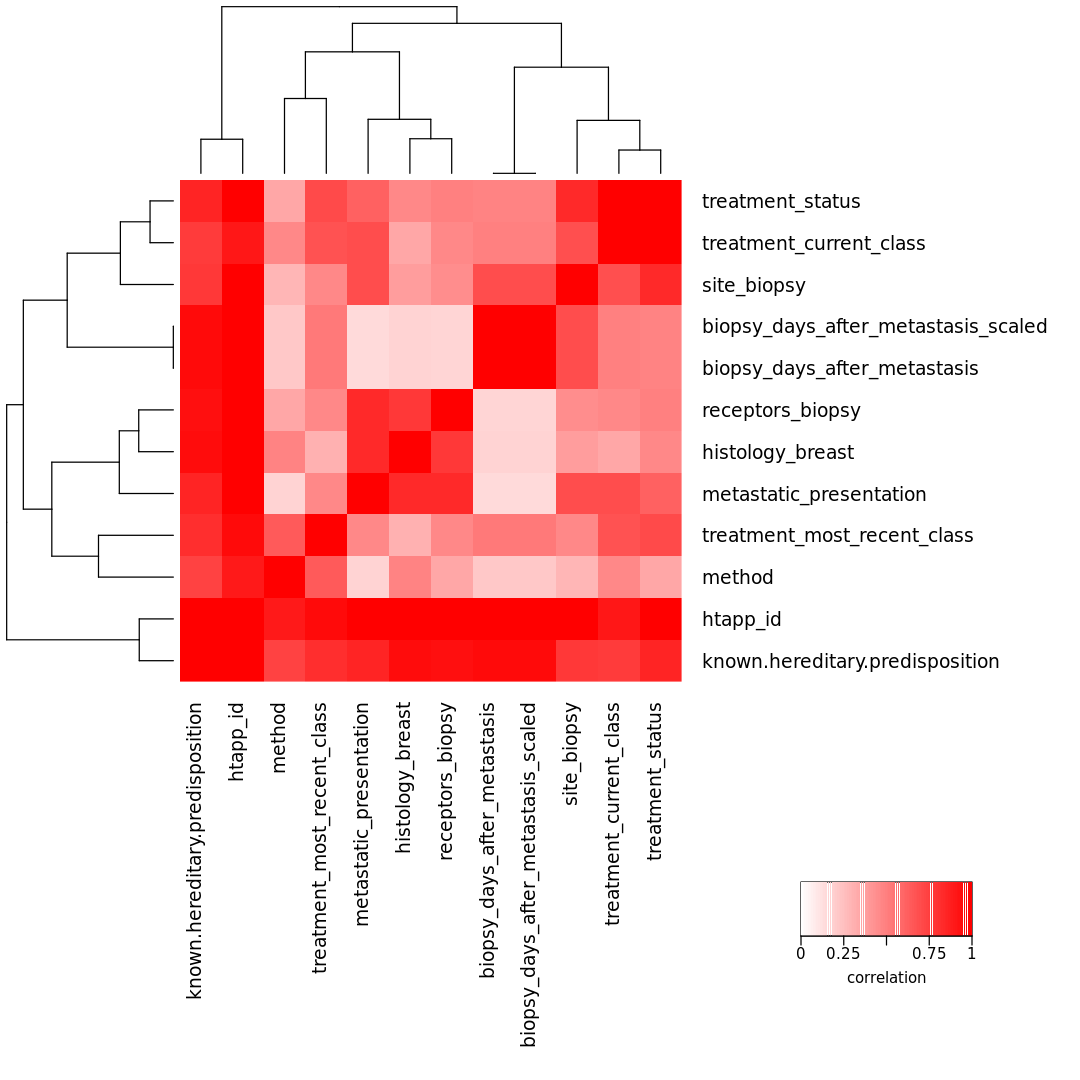

In [22]:
options(repr.plot.width = 9, repr.plot.height =9)
form <- ~ method+htapp_id+site_biopsy+receptors_biopsy+metastatic_presentation+biopsy_days_after_metastasis+histology_breast+known.hereditary.predisposition+biopsy_days_after_metastasis_scaled+treatment_status+treatment_current_class+treatment_most_recent_class
# Compute Canonical Correlation Analysis (CCA)
# between all pairs of variables
# returns absolute correlation value
C = canCorPairs( form, annot_df)
# Plot correlation matrix
pdf("feature_cor.pdf",width = 9,height=9)
plotCorrMatrix( C ,margins = c(20,20))
dev.off()
plotCorrMatrix( C ,margins = c(20,20))

### Explain expression variability

In [29]:
#run for compartemnts # all togeter initially run separately
compartments=c("_mal","_strom","_lym","_myel")
run="VarPart"
for (comp in compartments) {
    print(comp)
    expr=fread(paste0(baseDir,"/PyCache/pseudobulk_counts",comp,".tsv"))
    expr_mat=as.matrix(data.frame(expr,row.names = "V1",check.names = FALSE))
    expr_scale=apply(expr_mat,2,function(x){res=log((x+1)/sum(x+1));return(res)})
    
    include_samples=colnames(expr_mat)[colSums(expr_mat)>0]
    include_samples=include_samples[!include_samples%in%row.names(annot_df[annot_df$receptors_biopsy=="NA",])]
    

    #first gene is used to initialize. For stability use mean across all genes for this purpose.
    expr_scale_mean=t(as.matrix(colMeans(expr_scale)))
    row.names(expr_scale_mean)<-"means"
    expr_scale=rbind(expr_scale_mean,expr_scale)
    form <-  ~ (1|method)+(1|htapp_id)+(1|site_biopsy)+(1|receptors_biopsy)+(1|metastatic_presentation)+(1|histology_breast)+ (1|treatment_most_recent_class)
    
    
    stopifnot(colnames(expr_scale[,include_samples])==row.names(annot_df[include_samples,]))
    
    #suppressing ETA messages (not correctly compiled in jupyter)
    suppressMessages(varPart <- fitExtractVarPartModel(expr_scale[,include_samples], form, annot_df[include_samples,]))
    
    dir.create(run)
    write.table(varPart,paste0(run,"/varPart_expr",comp,".tsv"), sep="\t",quote=F,row.names = T)  
}


[1] "_mal"

Finished...
Total: 2099 s
[1] "_strom"

Finished...
Total: 2215 s


Warning message in dir.create(run):
"'VarPart' already exists"


[1] "_lym"

Finished...
Total: 2105 s


Warning message in dir.create(run):
"'VarPart' already exists"


[1] "_myel"

Finished...
Total: 2121 s


Warning message in dir.create(run):
"'VarPart' already exists"


In [30]:
compartments=c("_mal","_strom","_lym","_myel")
run="VarPart"
for (comp in compartments){
    varPart=read.table(paste0(run,"/varPart_expr",comp,".tsv"), sep="\t")
    vp <- sortCols( varPart )
    g1=plotPercentBars( vp[c("means","ESR1","PGR","ERBB2"),] )
    g2=plotVarPart( vp )
    
    varPart_long=melt(as.data.table(data.frame(varPart),keep.rownames = TRUE),id.vars = "rn")
    varPart_long[,rank:=rank(-value,ties.method = "random"),by="variable"]
    varPart_long[,topVar:=variable[order(rank)][1],by="rn"]
    g3=ggplot(varPart_long[rn%in%rn[rank<6]],aes(x=rn,y=value,fill=variable))+
    geom_bar(stat="identity",position="stack")+
    facet_wrap(~topVar,scale="free",ncol=4)+
    rotate_labels()+ylab("Variance explained")
    
 
    g4=tableGrob(varPart_long[rn%in%c("ESR1","PGR","ERBB2")])
    g5=tableGrob(varPart_long[variable=="receptors_biopsy"][order(rank)][1:20])
    
    
    pdf(paste0(run,"/varPart",comp,".pdf"),height=8,width=12)
        grid.arrange(
          grobs = list(g1,g2,g3),
          widths = c(2.5, 3),
        heights= c(1,1.5),
          layout_matrix = rbind(c(1, 2),c(3, 3)))
        grid.arrange(
          grobs = list(g4,g5),
          widths = c(1, 1),
          layout_matrix = rbind(c(1, 2)))
    dev.off()    
}

In [34]:
compartments=c("_mal","_strom","_lym","_myel")
run="VarPart"
vp_list=list()
for (comp in compartments){
    varPart=data.table(read.table(paste0(run,"/varPart_expr",comp,".tsv"), sep="\t"),keep.rownames = "gene")
    vp_long=melt(varPart,id.vars = "gene")  
    vp_long[,compartment:=comp,]
    vp_list[[comp]]=vp_long    
    }
vp_combined=rbindlist(vp_list)

In [44]:
vp_combined[,median_ve:=median(value),by=c("variable","compartment")]
vp_combined[,variable:=factor(variable,levels=unique(variable[order(median_ve,decreasing=T)])),]
vp_combined[,compartment:=factor(compartment,levels=c("_mal","_strom","_lym","_myel")),]

png 
  2

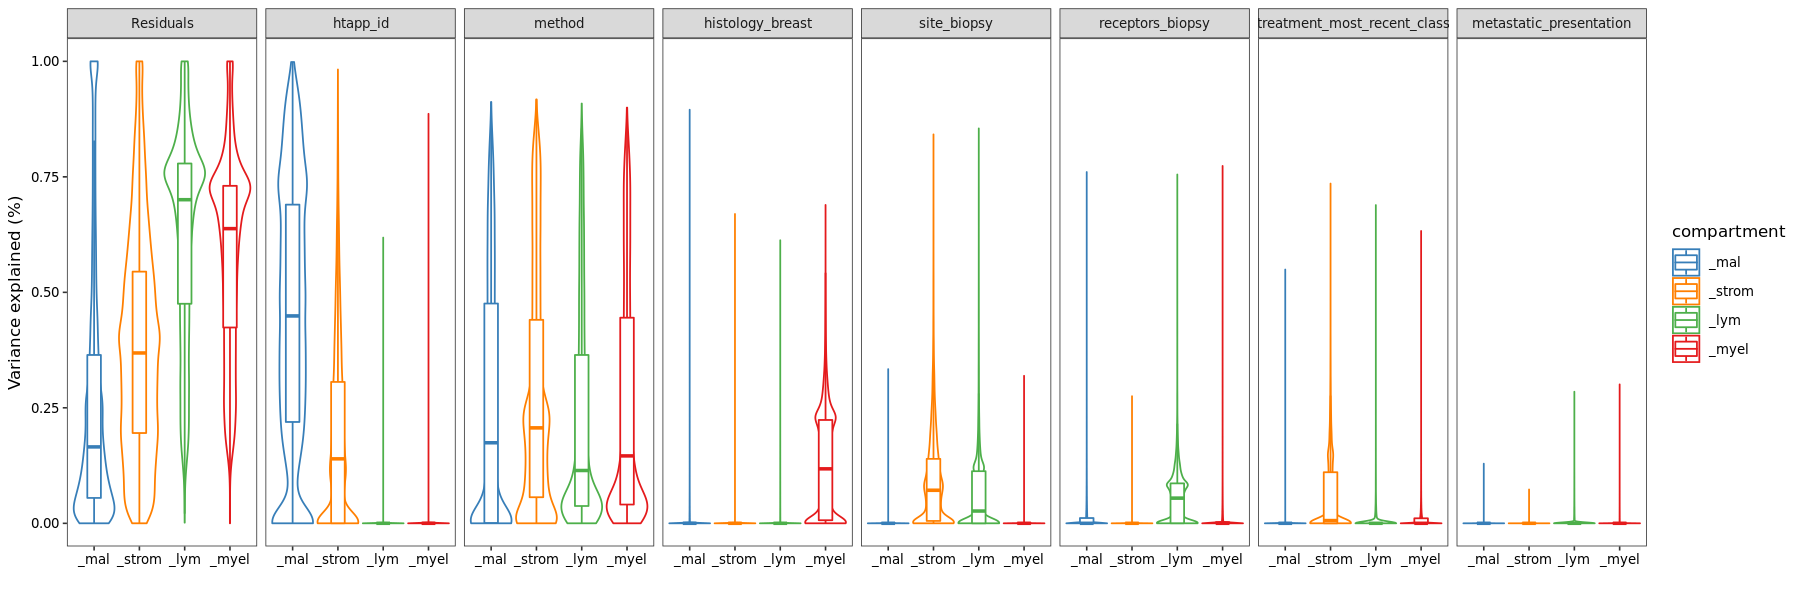

In [95]:
options(repr.plot.width = 15, repr.plot.height =5)
pl=ggplot(vp_combined,aes(x=compartment,y=value,col=compartment))+geom_violin(scale = "width")+
geom_boxplot(outlier.size = -1,width=0.3,position = position_dodge(width = 1))+
scale_color_manual(values = c("#377EB8", "#FF7F00", "#4DAF4A", "#E41A1C"))+facet_wrap(~variable,nrow=1)+
ylab("Variance explained (%)")+xlab("")
pdf(paste0(run,"/varPart_all_compartments.pdf"),height=5,width=15)
pl
dev.off()
pl

png 
  2

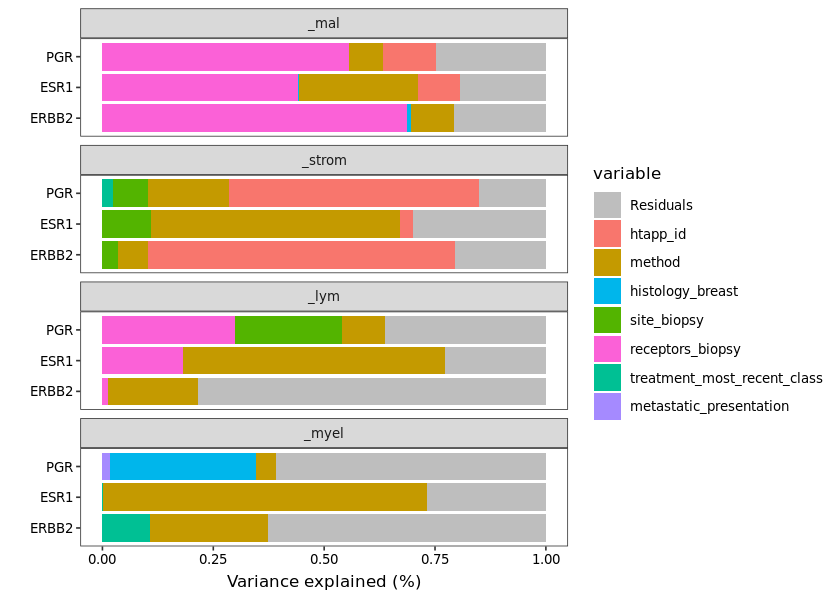

In [93]:
options(repr.plot.width = 7, repr.plot.height =5)
pl=ggplot(vp_combined[gene%in%c("ESR1","PGR","ERBB2")],aes(y=value,x=gene,fill=variable))+
geom_bar(stat="identity")+
facet_wrap(~compartment,ncol=1)+
scale_fill_manual(values=c("Residuals"="grey","htapp_id"="#F8766D", "method"="#C49A00", 
                           "site_biopsy"="#53B400", "treatment_most_recent_class"="#00C094", 
                           "histology_breast"="#00B6EB", "metastatic_presentation"="#A58AFF", "receptors_biopsy"="#FB61D7"))+
coord_flip()+ylab("Variance explained (%)")+xlab("")
pdf(paste0(run,"/varPart_receptors_all_compartments.pdf"),height=5,width=7)
pl
dev.off()
pl

#### Assess variance explained with pca

In [31]:
compartments=c("_mal","_strom","_lym","_myel")
run="VarPart"
comp=compartments[1]
varPart=read.table(paste0(run,"/varPart_expr",comp,".tsv"), sep="\t")

In [32]:
pca=princomp(varPart[varPart$Residuals<0.4&varPart$htapp_id<0.4&varPart$method<0.4,!names(varPart) %in% c("Residuals")])

In [33]:
summary(pca)

Importance of components:
                          Comp.1    Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     0.1738828 0.1421748 0.08862197 0.05421038 0.02774535
Proportion of Variance 0.4857307 0.3247339 0.12617265 0.04721145 0.01236696
Cumulative Proportion  0.4857307 0.8104646 0.93663722 0.98384867 0.99621562
                            Comp.6       Comp.7
Standard deviation     0.015321829 8.984801e-04
Proportion of Variance 0.003771409 1.296878e-05
Cumulative Proportion  0.999987031 1.000000e+00

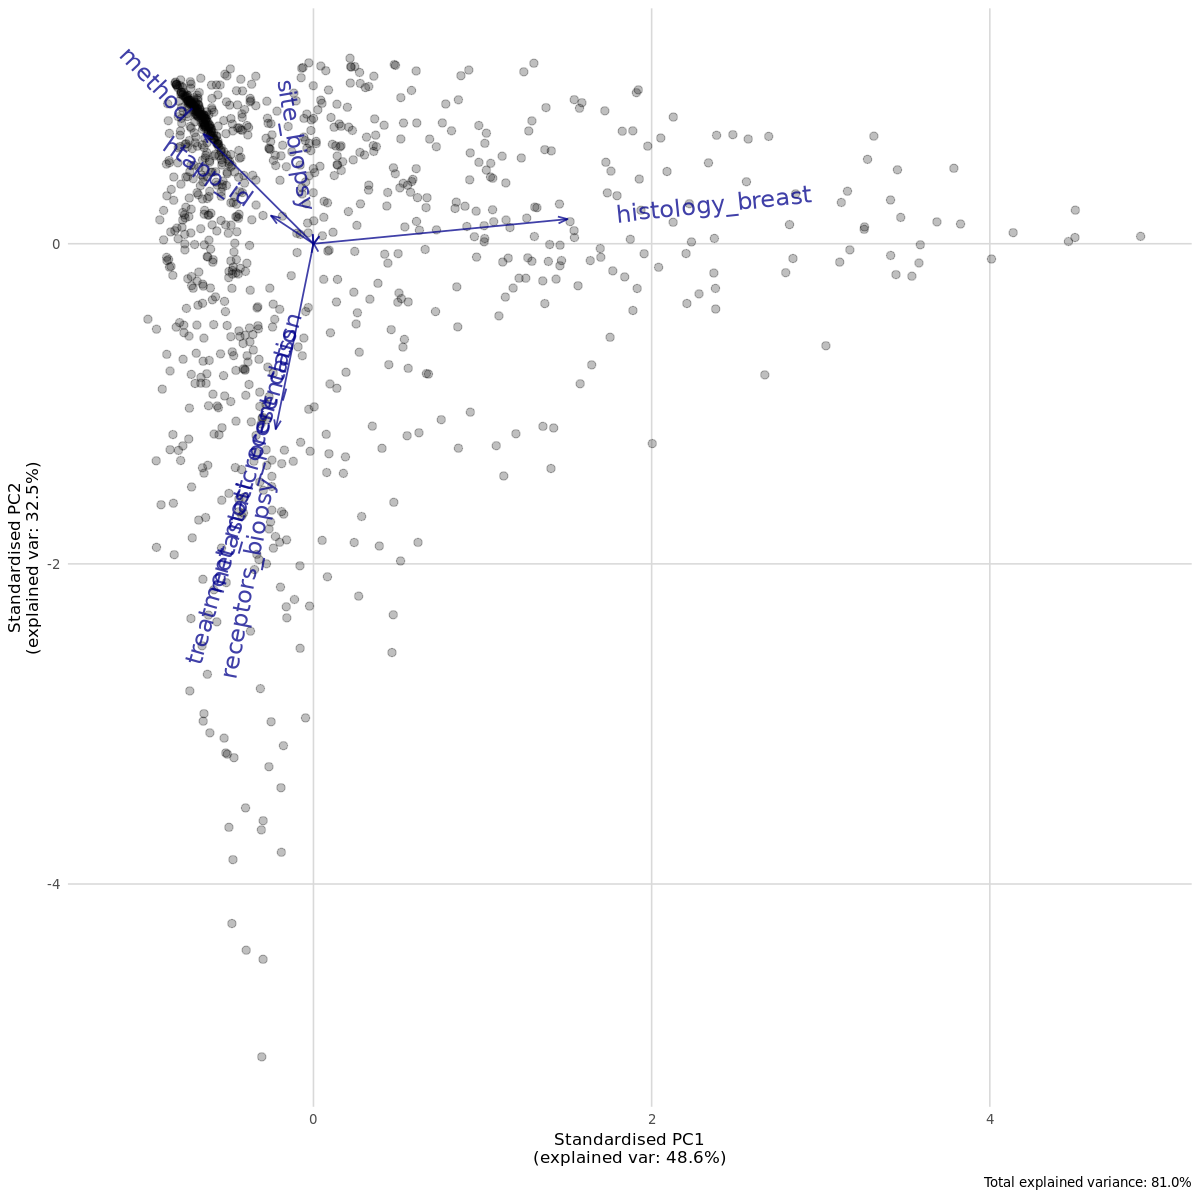

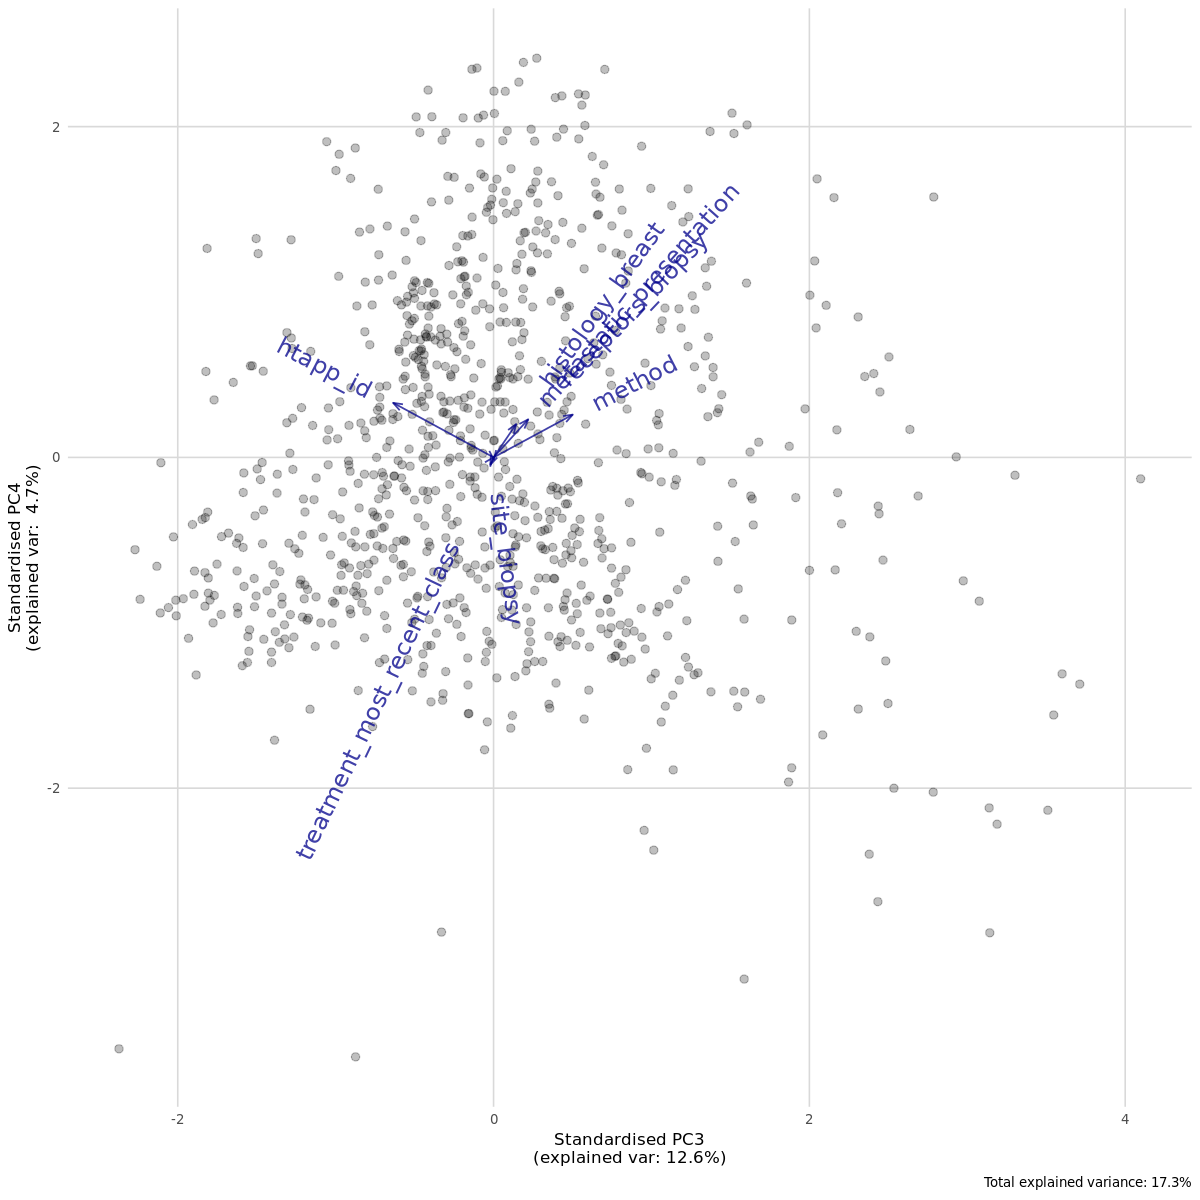

In [63]:
options(repr.plot.width = 10, repr.plot.height =10)
ggplot_pca(pca,choices = c(1,2),arrows_textsize = 5)
ggplot_pca(pca,choices = c(3,4),arrows_textsize = 5)

#### Look into genes

In [61]:
plot_expr <-function(comp,gene,var){
    expr=fread(paste0(baseDir,"/PyCache/pseudobulk_counts_",comp,".tsv"))
    expr_mat=as.matrix(data.frame(expr,row.names = "V1",check.names = FALSE))
    expr_cpm=log2(apply(expr_mat,2,function(x){res=x/sum(x)*10^6;return(res)})+1)
    include_samples=colnames(expr_mat)[colSums(expr_mat)>0]
    stopifnot(colnames(expr_cpm[,include_samples])==row.names(annot_df[include_samples,]))

    GE <- data.frame( log2_cpm = expr_cpm[gene,include_samples], var = annot_df[include_samples,var])
    plotStratify( log2_cpm ~ var, GE, main=gene)    
}



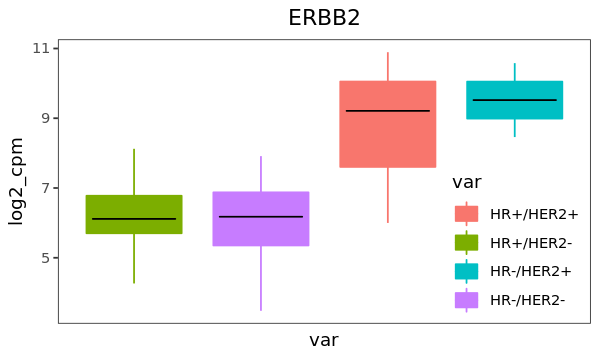

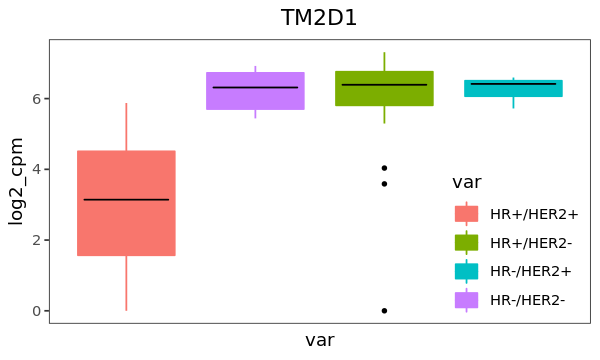

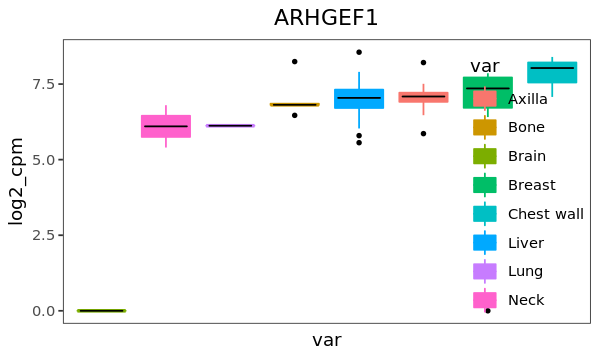

In [66]:
options(repr.plot.width = 5, repr.plot.height =3)
plot_expr("mal","ERBB2","receptors_biopsy_simpl")
plot_expr("lym","TM2D1","receptors_biopsy_simpl")
plot_expr("lym","ARHGEF1","site_biopsy")

### (Hierarchical) clustering of samples based on pseudobulk

In [26]:
comp="_mal"
expr_df=read.table(paste0(baseDir,"/PyCache/pseudobulk_counts",comp,".tsv"),row.names = 1,check.names = FALSE,)

In [64]:
#exclude samples with a low number of malignant cells
exclude_smp=c("HTAPP-232-SMP-6759","HTAPP-586-SMP-8599","HTAPP-414-SMP-1681","HTAPP-330-SMP-1082","HTAPP-382-SMP-1441","HTAPP-364-SMP-1321")
#exclude samples with no malignant cells
include_samples=colnames(expr_df)[colSums(expr_df)>0]
#exclude samples with no receptor annotation
include_samples=include_samples[!include_samples%in%c(row.names(annot_df[annot_df$receptors_biopsy=="NA",]),exclude_smp)]

In [28]:
expr_mat=as.matrix(expr_df[,include_samples])
expr_scale=apply(expr_mat,2,function(x){res=log((x+1)/sum(x+1));return(res)})

In [29]:
annot_filt=annot_df[colnames(expr_mat),c("method","receptors_biopsy","receptors_biopsy_simpl","site_biopsy","mode","PAM50.subtype_sc"),]

In [30]:
mod = model.matrix(~as.factor(receptors_biopsy_simpl)+as.factor(site_biopsy), data=annot_filt)

In [31]:
comb=ComBat(expr_scale,annot_filt$method,mod = mod)

Found2batches

Adjusting for10covariate(s) or covariate level(s)



Standardizing Data across genes


Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




In [32]:
comb[1:5,1:5]

,HTAPP-225-SMP-6756,HTAPP-589-SMP-2851,HTAPP-231-SMP-6758,HTAPP-862-SMP-7059,HTAPP-862-SMP-7060
AL627309.1,-12.65561,-12.88244,-13.06127,-12.15063,-12.14427
AL732372.1,-14.35339,-14.39040,-15.87658,-17.54676,-17.23223
AC114498.1,-15.91687,-15.01497,-15.23464,-15.80618,-17.43928
AL669831.2,-14.84722,-16.84552,-17.61268,-17.98614,-16.86423
AL669831.5,-10.23070,-10.78837,-11.26925,-11.11691,-10.77995


In [33]:
des=annot_filt
des$ID=row.names(des)

In [34]:
feat_filt=featurefilter(comb,percentile = 0.4)

***feature filter function***

extracting the most variable: 0.4 percent

features to start with: 26538

performing calculations for median absolute deviation

printing topN most variable features with statistics...



              feature      mean       var       sd      MAD
SCGB2A2       SCGB2A2 -11.02274 16.590749 4.073174 5.517277
CALML5         CALML5 -12.01710 13.712187 3.702997 5.409916
TFAP2B         TFAP2B -12.03509 11.430543 3.380909 4.810883
TFF1             TFF1 -11.87241 11.179110 3.343518 4.165357
LINC01087   LINC01087 -12.74339  9.056485 3.009399 4.027148
AC093001.1 AC093001.1 -11.88379 10.163107 3.187963 3.971694
PEG10           PEG10 -12.61712  7.590055 2.755005 3.908063
GP2               GP2 -13.43551  6.955322 2.637294 3.796202
LRP2             LRP2 -11.22819  6.166008 2.483145 3.760206
LTF               LTF -12.56203  9.661820 3.108347 3.748524
ANKRD30B     ANKRD30B -11.11622  6.643690 2.577536 3.686537
IFI27           IFI27 -10.66133  6.883251 2.623595 3.647980
MUC15           MUC15 -13.97260  7.037632 2.652854 3.637781
LY6K             LY6K -13.68623  6.449205 2.539529 3.630819
KCNJ3           KCNJ3 -12.78384 12.498444 3.535314 3.578387
APOD             APOD -12.30700  7.58721

features remaining: 107



***M3C***

method: Monte Carlo simulation

clustering algorithm: hc

annotation: yes

running simulations...



  |======================================================================| 100%


done.

running consensus cluster algorithm for real data...

done.



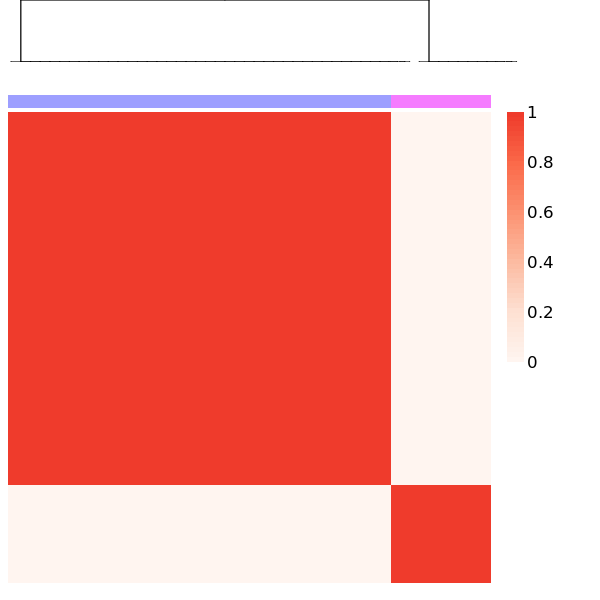

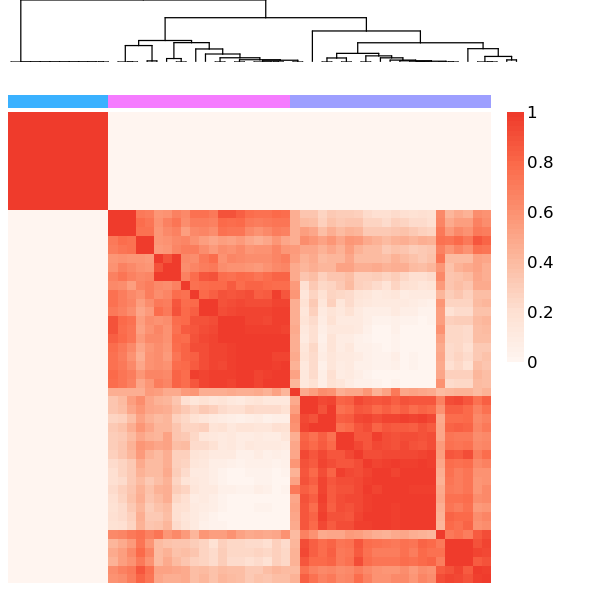

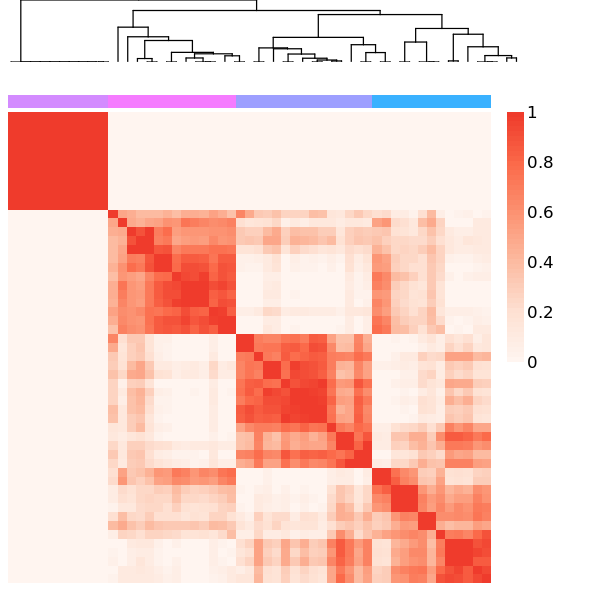

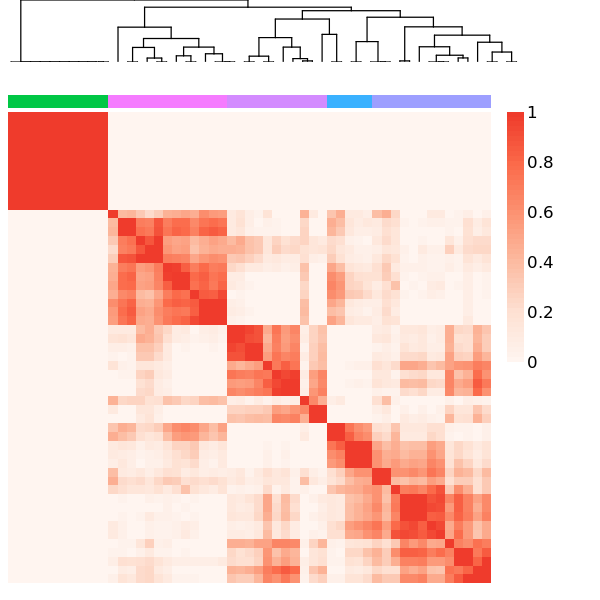

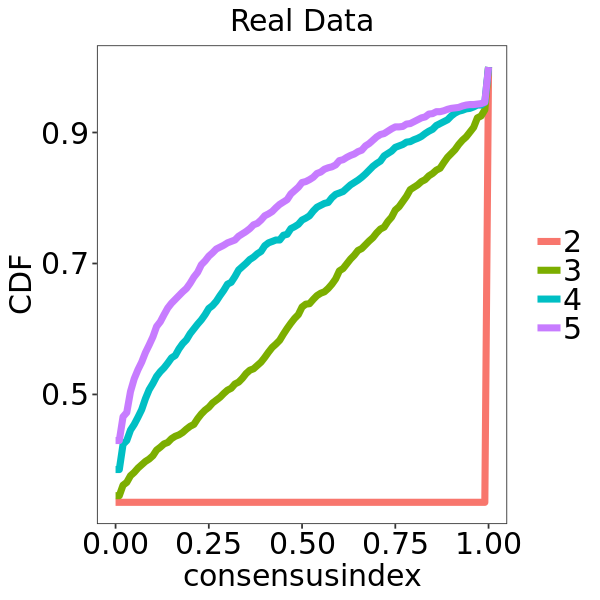

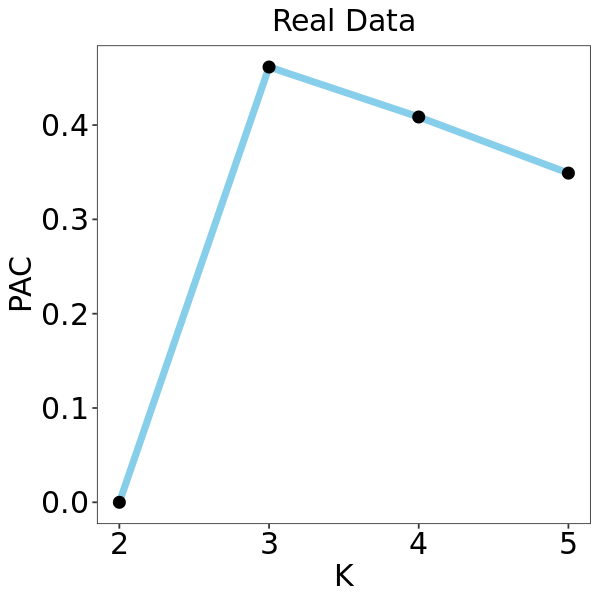

optimal K: 2



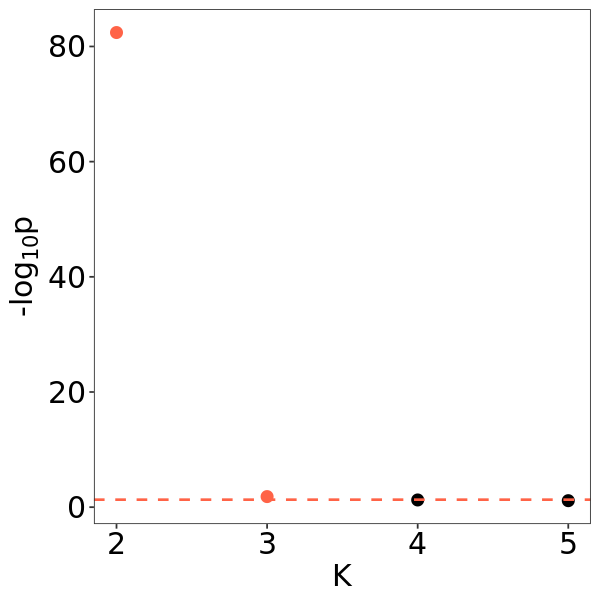

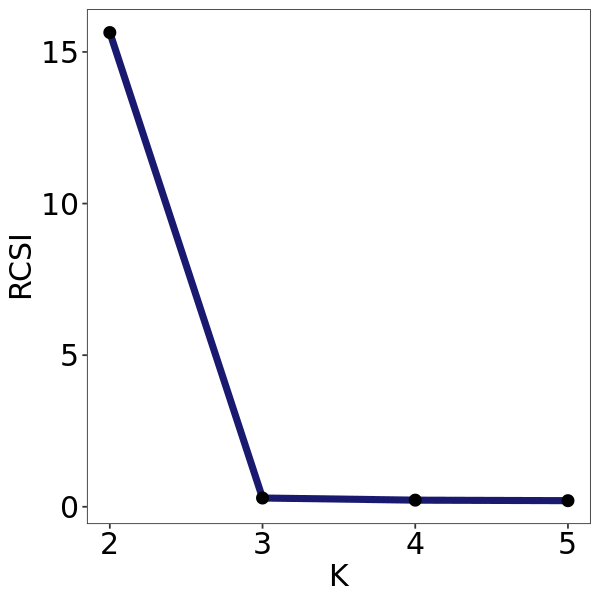

In [35]:
options(repr.plot.width = 5, repr.plot.height =5)
res <- M3C(feat_filt$filtered_data, des = des ,clusteralg = "hc",maxK = 5,showheatmaps = TRUE, iters=25)

In [36]:
m3c_cl=res$realdataresults[[2]]$ordered_annotation
row.names(m3c_cl)=gsub("\\.","-",row.names(m3c_cl))

In [37]:
m3c_cl$pat=gsub("-SMP.*","",row.names(m3c_cl))
m3c_cl[!m3c_cl$pat%in%m3c_cl$pat[duplicated(m3c_cl$pat)],]$pat<-"ND"

In [44]:
cols=list(pat=c("HTAPP-223"="green","HTAPP-262"="red","HTAPP-862"="blue","HTAPP-887"="yellow","ND"="black"),         
receptors_biopsy=c("ER+/PR+/HER2+"="darkblue","ER+/PR+/HER2-"="blue","ER+/PR-/HER2+"="cornflowerblue","ER+/PR-/HER2-"="deepskyblue","ER-/PR-/HER2+"="darkgreen","ER-/PR-/HER2-"="darkolivegreen1"),
         receptors_biopsy_simpl=unlist(rc_colors),
         mode=c("V2"="grey","V3"="black"),
         method= c("snRNAseq"="grey","scRNAseq"="black"),
        site_biopsy=unlist(ti_colors),
         PAM50.subtype_sc=c("Basal"="darkolivegreen1","Her2"="darkgreen","LumA"="darkblue","LumB"="lightblue"))

In [34]:
cols=list(pat=c("HTAPP-223"="green","HTAPP-262"="red","HTAPP-862"="blue","HTAPP-887"="yellow","ND"="black"),         
receptors_biopsy=c("ER+/PR+/HER2+"="darkblue","ER+/PR+/HER2-"="blue","ER+/PR-/HER2+"="cornflowerblue","ER+/PR-/HER2-"="deepskyblue","ER-/PR-/HER2+"="darkgreen","ER-/PR-/HER2-"="darkolivegreen1"),
         receptors_biopsy_simpl=c("HR+/HER2+"="darkblue","HR+/HER2-"="lightblue","HR-/HER2+"="darkgreen","HR-/HER2-"="darkolivegreen1"),
         mode=c("V2"="grey","V3"="black"),
         method= c("snRNAseq"="grey","scRNAseq"="black"),
         PAM50.subtype_sc=c("Basal"="darkolivegreen1","Her2"="darkgreen","LumA"="darkblue","LumB"="lightblue"))

In [20]:
pca=prcomp(t(feat_filt$filtered_data))

In [21]:
sel_rot=names(sort(sqrt(pca$rotation[,c("PC1")]^2+pca$rotation[,c("PC2")]^2),decreasing=TRUE)[1:30])

In [22]:
pca_red=pca
pca_red$rotation=pca_red$rotation[sel_rot,]

png 
  2

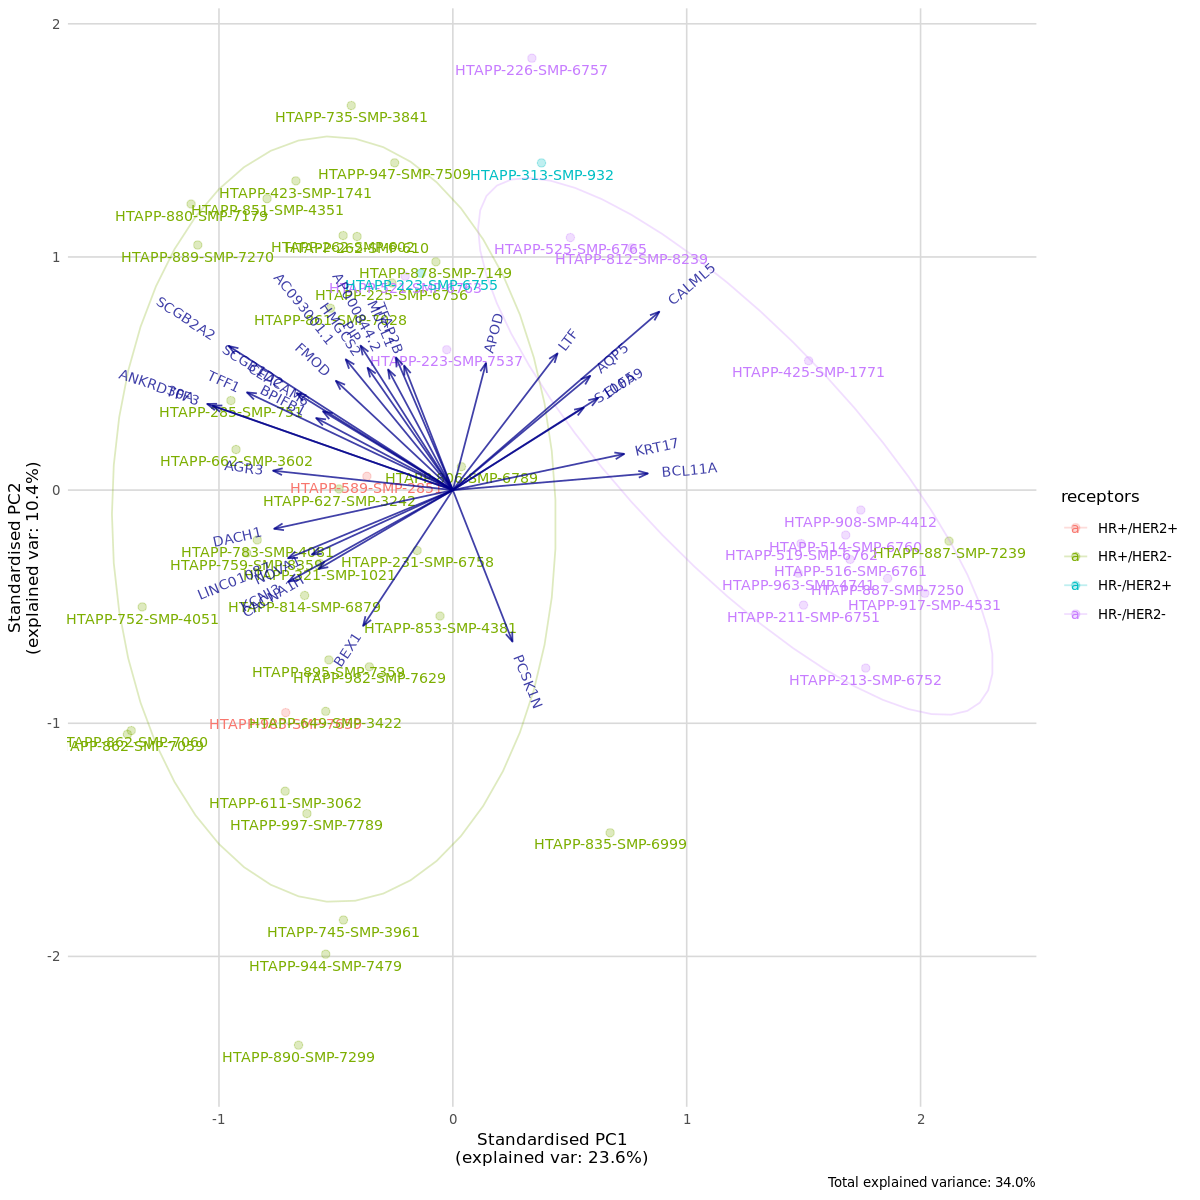

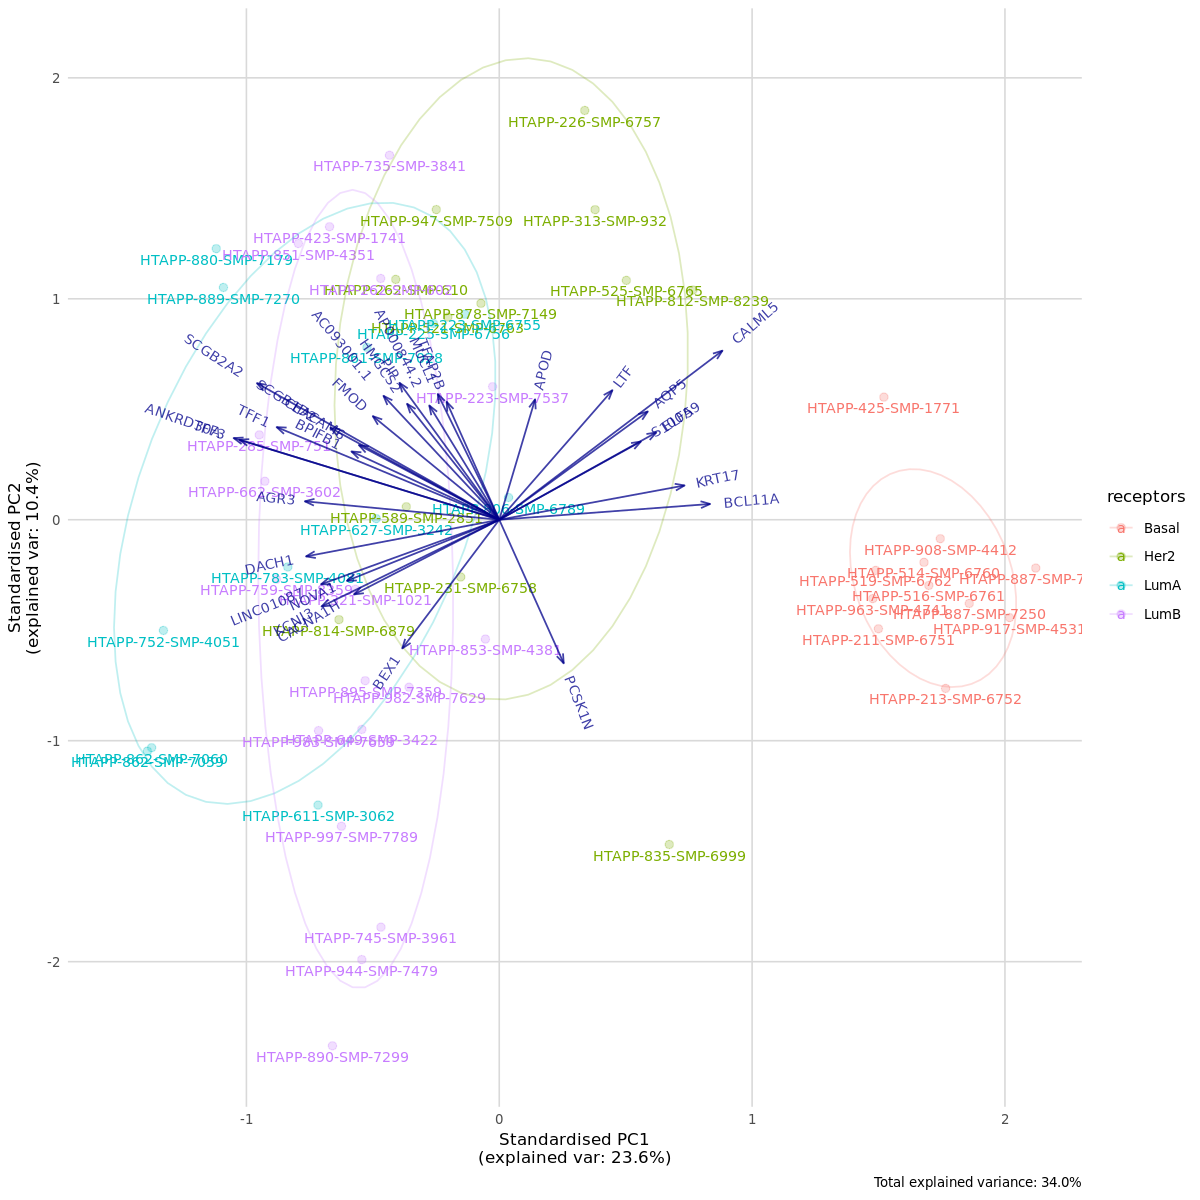

In [24]:
options(repr.plot.width = 10, repr.plot.height =10)
group_name="receptors"
pl1=ggplot_pca(pca_red,labels =row.names(pca_red$x),groups=annot_filt[row.names(pca_red$x),]$receptors_biopsy_simpl)
pl2=ggplot_pca(pca_red,labels =row.names(pca_red$x),groups=annot_filt[row.names(pca_red$x),]$PAM50.subtype_sc)

pdf("mal_pseudobulk_pca.pdf",width = 10,height = 10)
pl1
pl2
dev.off()
pl1
pl2

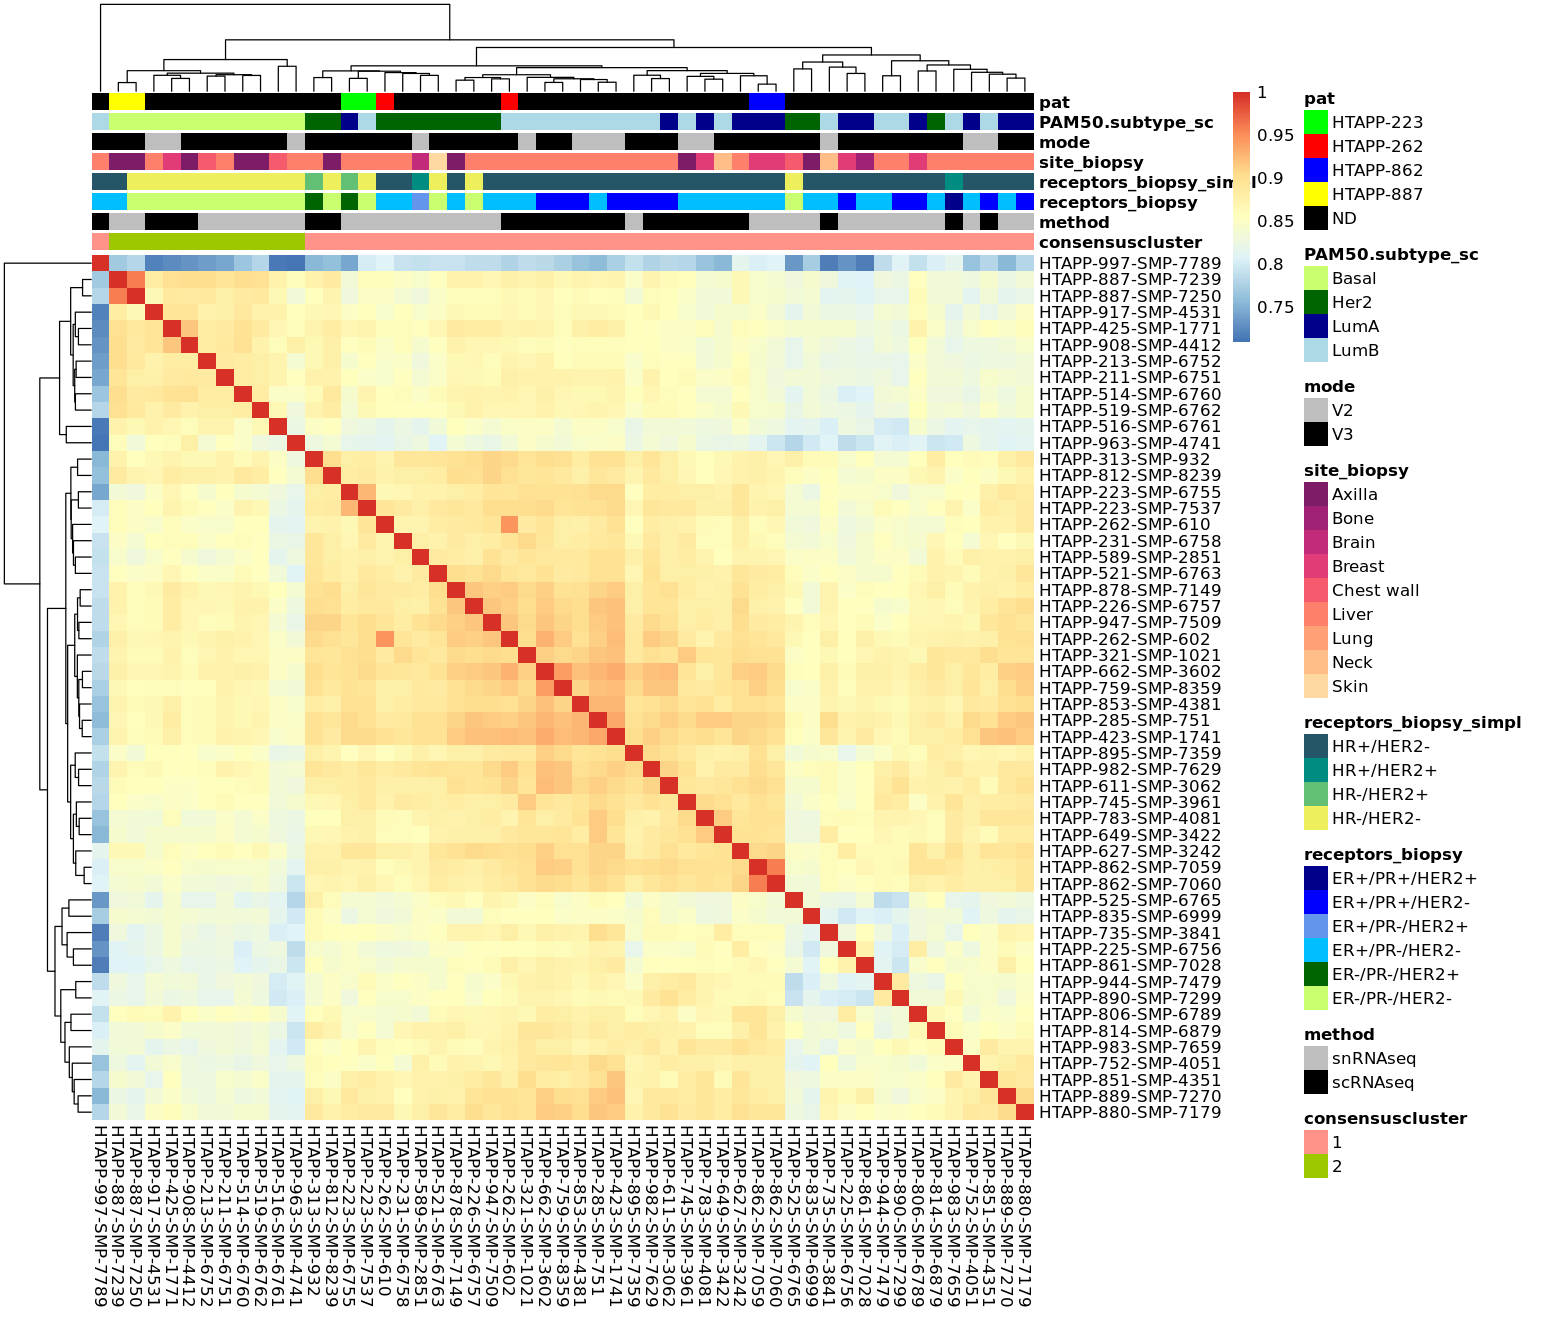

In [46]:
#using all genes
options(repr.plot.width = 13, repr.plot.height =11)
cors=cor(comb)
pheatmap(cors,annotation_col = m3c_cl,annotation_colors = cols)

png 
  2

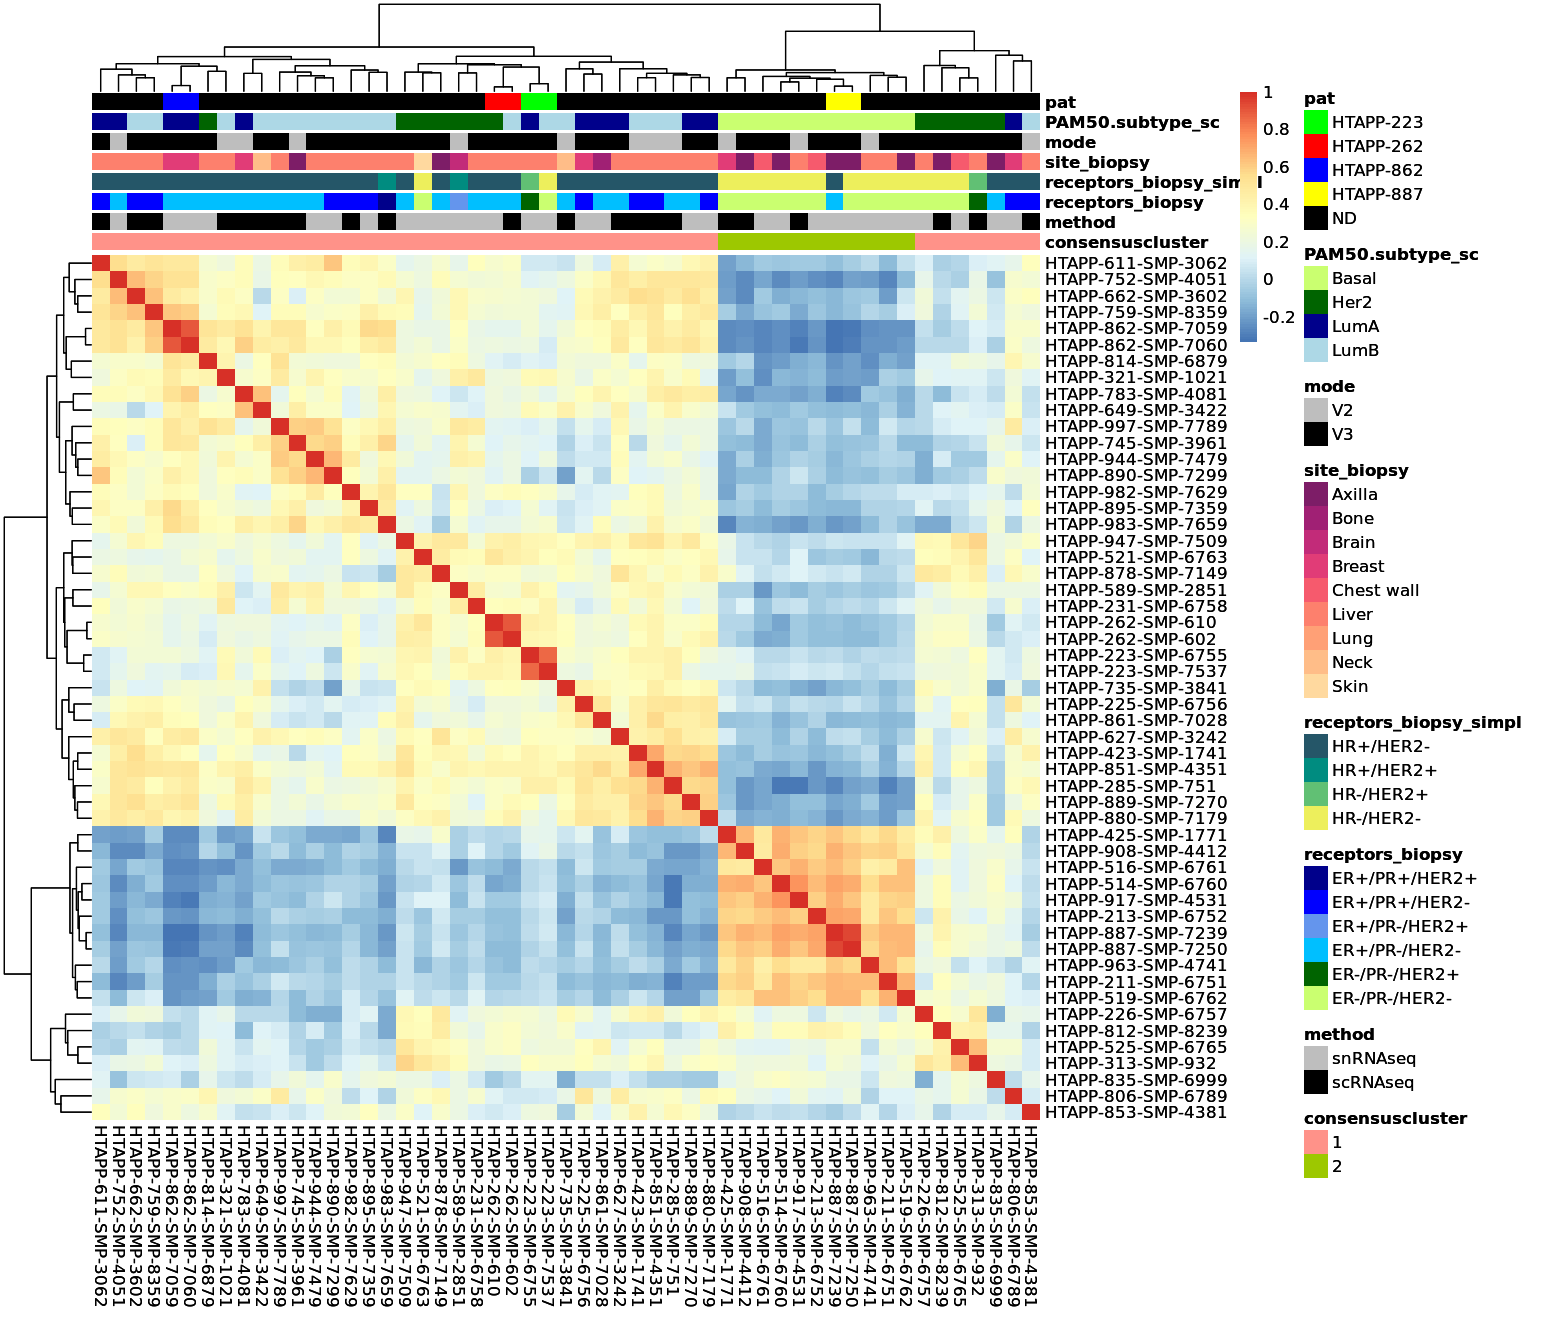

In [47]:
#variable genes
options(repr.plot.width = 13, repr.plot.height =11)
cors=cor(feat_filt$filtered_data)
pl=pheatmap(cors,annotation_col = m3c_cl,annotation_colors = cols)
pdf("cor_heatmap_var_genes.pdf",width = 13,height=11)
print(pl)
dev.off()
pl

In [38]:
groups_col="PAM50.subtype_sc"
#groups_col="receptors_biopsy_simpl"
cors=cor(feat_filt$filtered_data)

gs=unique(m3c_cl[,groups_col])
res_all=data.table()
for (g in gs){
    smps=row.names(m3c_cl[m3c_cl[,groups_col]==g,])
    vals=as.data.table(reshape2::melt(cors[smps,smps]))
    vals[,group:=g,]
    vals[,annot:=groups_col,]
    res_all=rbindlist(list(res_all,vals))
}
res_all[,pat1:=gsub("-SMP.*","",Var1),]
res_all[,pat2:=gsub("-SMP.*","",Var2),]
res_all=res_all[pat1!=pat2]

pvals=as.data.table(t(combn(x=gs,m=2)))
pvals[,pval:=wilcox.test(res_all[group==V1,]$value,res_all[group==V2,]$value)$p.value,by=1:nrow(pvals)]

png 
  2

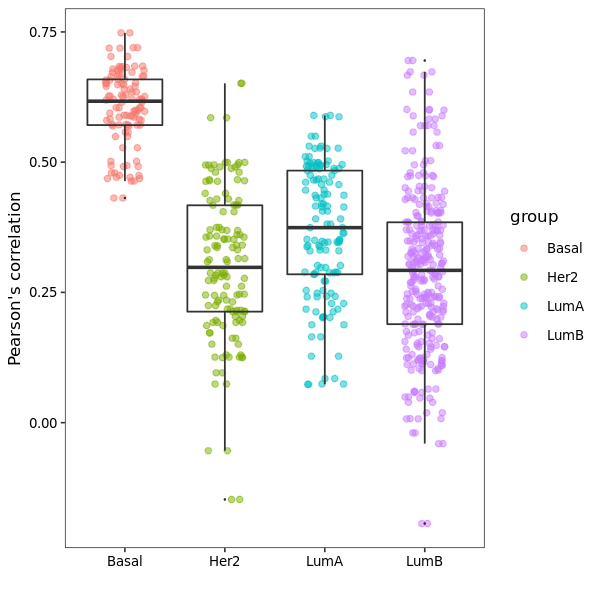

In [41]:
options(repr.plot.width = 5, repr.plot.height =5)
pl=ggplot(res_all,aes(x=group,y=value))+
geom_point(position=position_jitter(width=0.2),alpha=0.5,aes(col=group))+
geom_boxplot(fill="transparent",outlier.size = 0)+
ylab("Pearson's correlation")+xlab("")
pdf("cor_boxpl_var_genes.pdf",width = 5, height=5)
pl
dev.off()
pl

In [42]:
pvals

V1,V2,pval
<chr>,<chr>,<dbl>
Basal,Her2,9.178667e-36
Basal,LumB,2.845974e-45
Basal,LumA,6.418922e-33
Her2,LumB,3.418228e-01
Her2,LumA,1.513523e-04
LumB,LumA,2.858337e-07


### Explain cell type composition variability

In [9]:
obs=fread(paste0(baseDir,"/PyCache/fresh_frozen_combined_obs.tsv"))

In [10]:
cell_counts=obs[,.N,by=c('name','cell_type')]

In [11]:
cell_counts_df=dcast(cell_counts,cell_type~name,value.var = "N")
cell_counts_df[is.na(cell_counts_df)]=0

In [14]:
cell_counts_mat=as.matrix(data.frame(cell_counts_df,row.names = "cell_type",check.names = FALSE))
include_samples=colnames(cell_counts_mat)
include_samples=include_samples[!include_samples%in%row.names(annot_df[annot_df$receptors_biopsy=="NA",])]
cell_counts_mat=cell_counts_mat[,include_samples]

In [52]:
#center log ratio (gives quite similar results as pearson's contingeny ratio)
#just used as check
geoMean=exp(colMeans(log(cell_counts_mat+1))) #geometric mean
cell_counts_scale=(cell_counts_mat+1)/geoMean

In [15]:
# Pearson's contingency ratio (normalization to express excess over assumption of randomnes)
#  https://econ-papers.upf.edu/papers/908.pdf  page 10
cSums=colSums(cell_counts_mat+1)
rSums=rowSums(cell_counts_mat+1)
aSum=sum(cell_counts_mat+1)
cell_counts_scale=(cell_counts_mat+1)*aSum/outer(rSums,cSums)

In [16]:
cell_counts_mat[1:5,1:5]
cell_counts_scale[1:5,1:5]

,HTAPP-211-SMP-6751,HTAPP-213-SMP-6752,HTAPP-223-SMP-6755,HTAPP-223-SMP-7537,HTAPP-225-SMP-6756
Adipocytes,0,0,0,0,484
B,0,0,2,0,0
B_plasma,0,0,366,0,31
Chondrocyte,0,0,0,0,0
Endothelial,0,0,0,0,0


,HTAPP-211-SMP-6751,HTAPP-213-SMP-6752,HTAPP-223-SMP-6755,HTAPP-223-SMP-7537,HTAPP-225-SMP-6756
Adipocytes,0.051646213,0.084815435,0.055784687,0.064002431,130.62577562
B,0.006819446,0.011199162,0.022097689,0.008450980,0.03556295
B_plasma,0.009376036,0.015397694,3.716737099,0.011619227,1.56465251
Chondrocyte,0.014019773,0.023023820,0.015143194,0.017373966,0.07311216
Endothelial,0.006056084,0.009945539,0.006541366,0.007504986,0.03158207


In [16]:
response=cell_counts_scale
vars=annot_df[include_samples,]

response_mean=t(as.matrix(colMeans(response)))
row.names(response_mean)<-"means"
response=rbind(response_mean,response)

stopifnot(colnames(response)==row.names(vars))

form <-  ~ (1|method)+(1|htapp_id)+(1|site_biopsy)+(1|receptors_biopsy)+(1|metastatic_presentation)+(1|histology_breast)+ (1|treatment_most_recent_class)

suppressMessages(varPart_cells <- fitExtractVarPartModel( log(response), form, vars))
write.table(varPart_cells,"varPart_cells.tsv", sep="\t",quote=F,row.names = F)

Warning message:
"executing %dopar% sequentially: no parallel backend registered"



Finished...
Total: 3 s


png 
  2

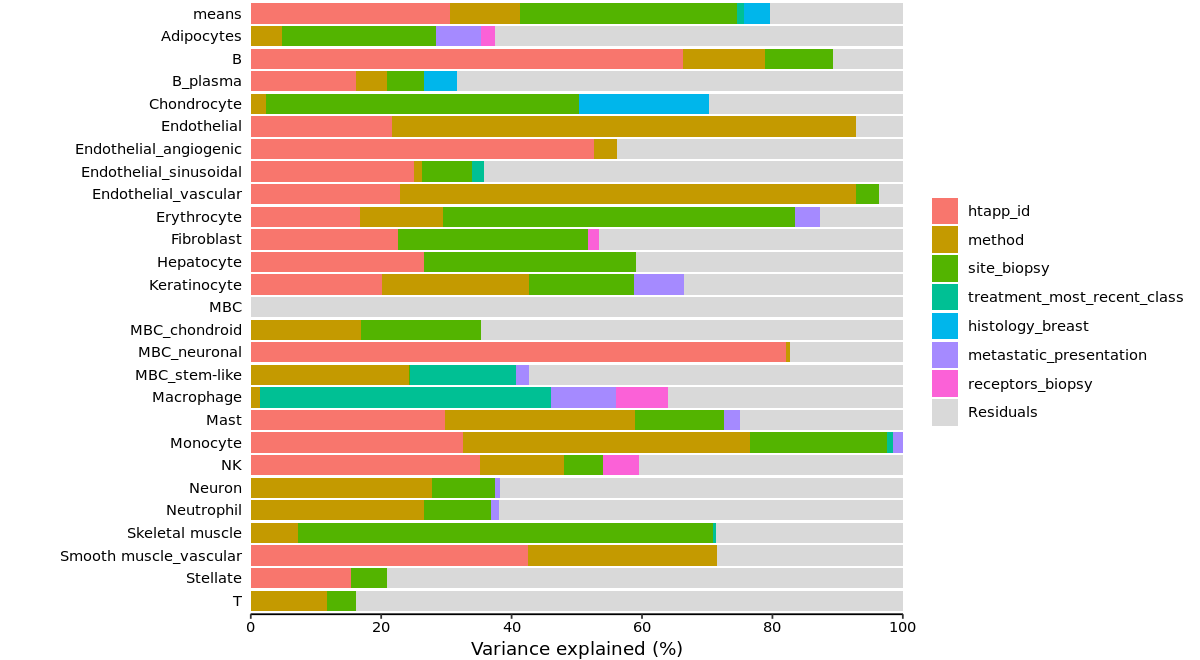

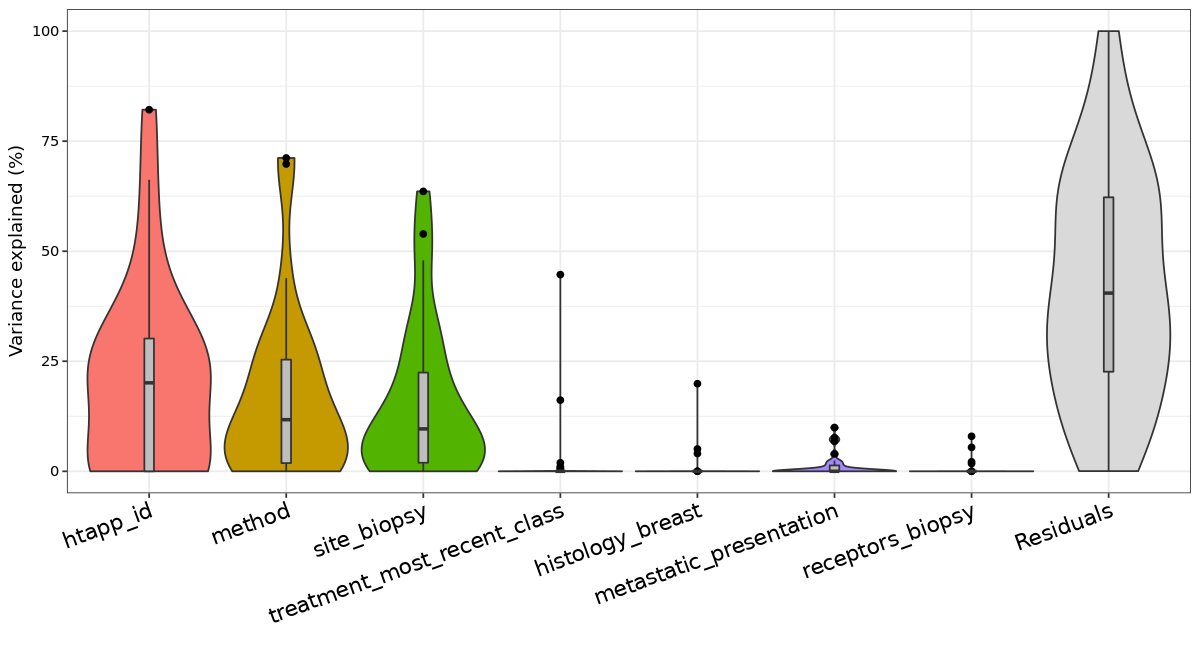

In [17]:
options(repr.plot.width = 10, repr.plot.height =5.5)
vp_cells <- sortCols( varPart_cells )

pdf("varPart_cells.pdf",width=10,height=5.5)
plotPercentBars( vp_cells)
plotVarPart( vp_cells )
dev.off()

plotPercentBars( vp_cells)
plotVarPart( vp_cells )

In [57]:
plot_ctfr <-function(mat,ct,var){

    GE <- data.table( score = mat[ct,], var = annot_df[colnames(mat),var])
    
    GE[,N_var:=.N,by=var]
    GE[N_var<3,var:="other",]
    GE[,median_score:=median(score),by=var]
    GE[,var:=factor(var,levels=unique(var[order(median_score)])),]
    ggplot(GE,aes(x=var,y=score))+geom_boxplot(outlier.color = "transparent")+
    geom_point(position=position_jitter(width=0.2),alpha=0.6)+ggtitle(ct)+
    ylab("frequency score")+xlab("")+rotate_labels()
       
}



png 
  2

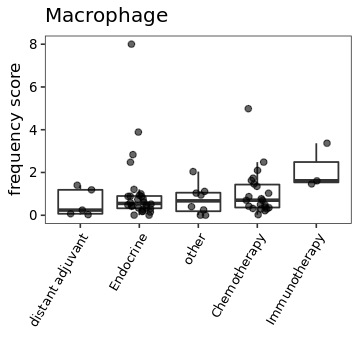

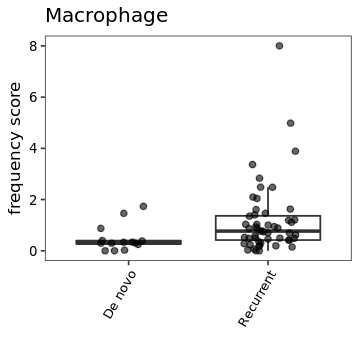

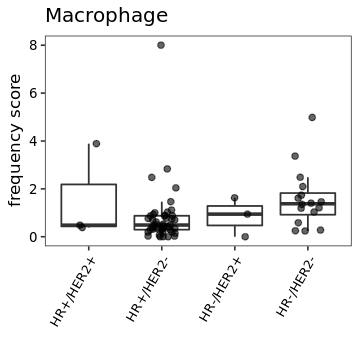

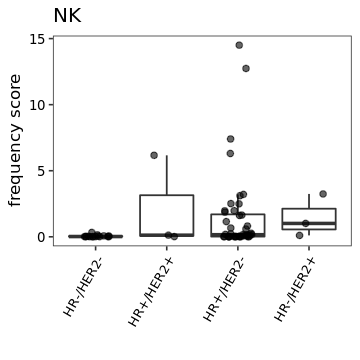

In [59]:
options(repr.plot.width = 3, repr.plot.height =3)
p1=plot_ctfr(cell_counts_scale,"Macrophage","treatment_most_recent_class")
p2=plot_ctfr(cell_counts_scale,"Macrophage","metastatic_presentation")
p3=plot_ctfr(cell_counts_scale,"Macrophage","receptors_biopsy_simpl")
p4=plot_ctfr(cell_counts_scale,"NK","receptors_biopsy_simpl")
pdf("ct_compare.pdf",width=3,height=3)
p1
p2
p3
p4
dev.off()
p1
p2
p3
p4

In [18]:
pca=princomp(varPart_cells)

In [19]:
summary(pca)

Importance of components:
                          Comp.1    Comp.2    Comp.3     Comp.4      Comp.5
Standard deviation     0.3068305 0.2064345 0.1966025 0.10713551 0.037866713
Proportion of Variance 0.4984233 0.2256138 0.2046348 0.06076705 0.007591306
Cumulative Proportion  0.4984233 0.7240372 0.9286719 0.98943899 0.997030292
                           Comp.6       Comp.7       Comp.8
Standard deviation     0.02029297 0.0122118961 3.440156e-09
Proportion of Variance 0.00218018 0.0007895279 6.265528e-17
Cumulative Proportion  0.99921047 1.0000000000 1.000000e+00

png 
  2

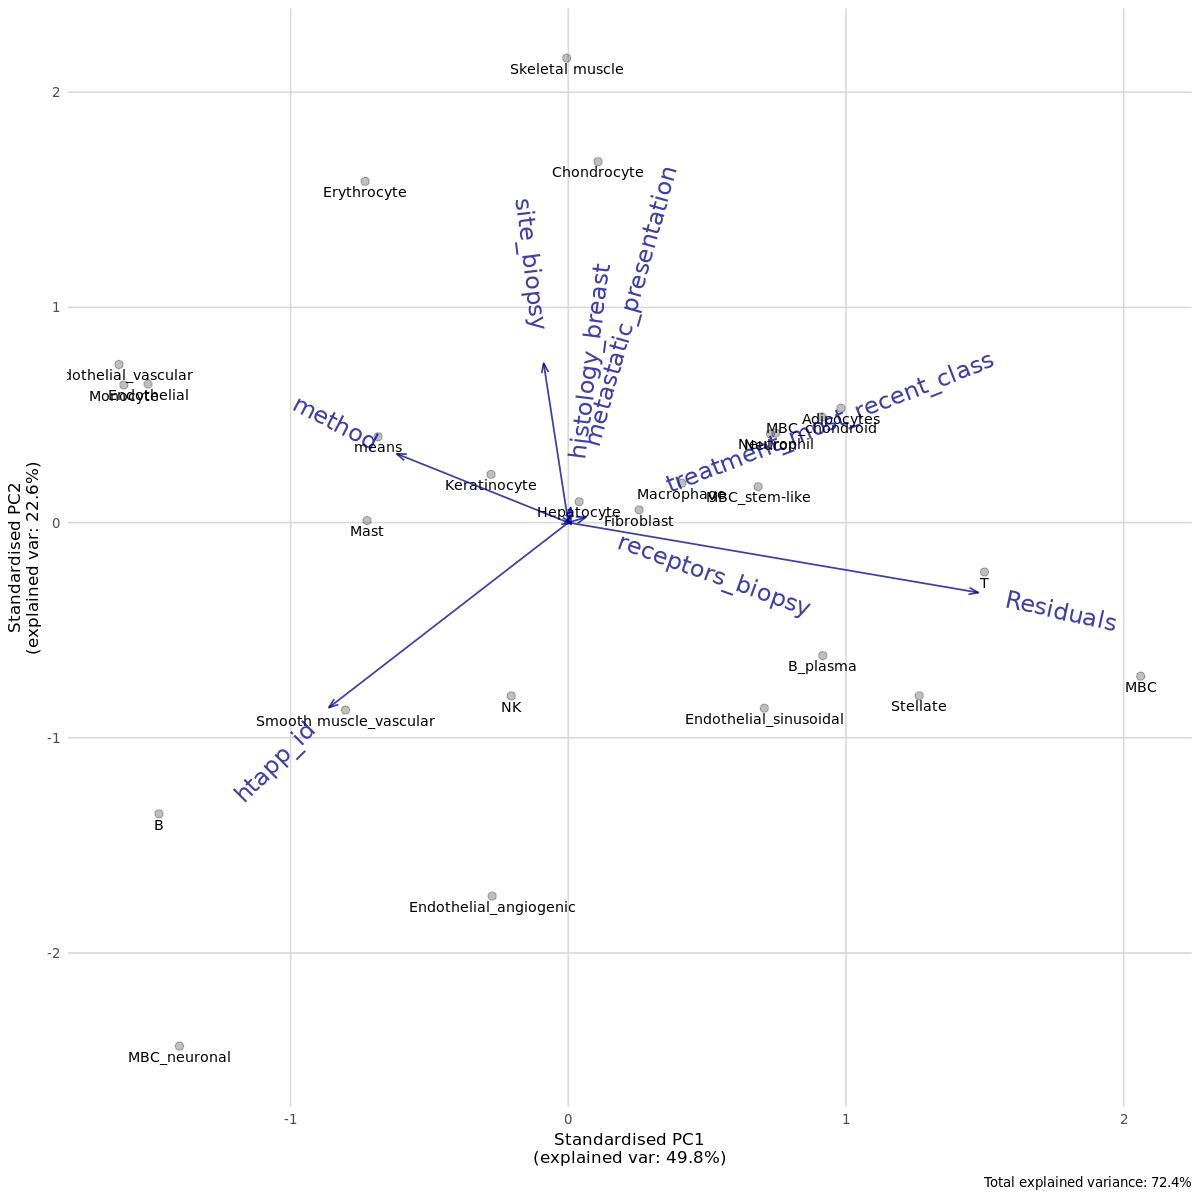

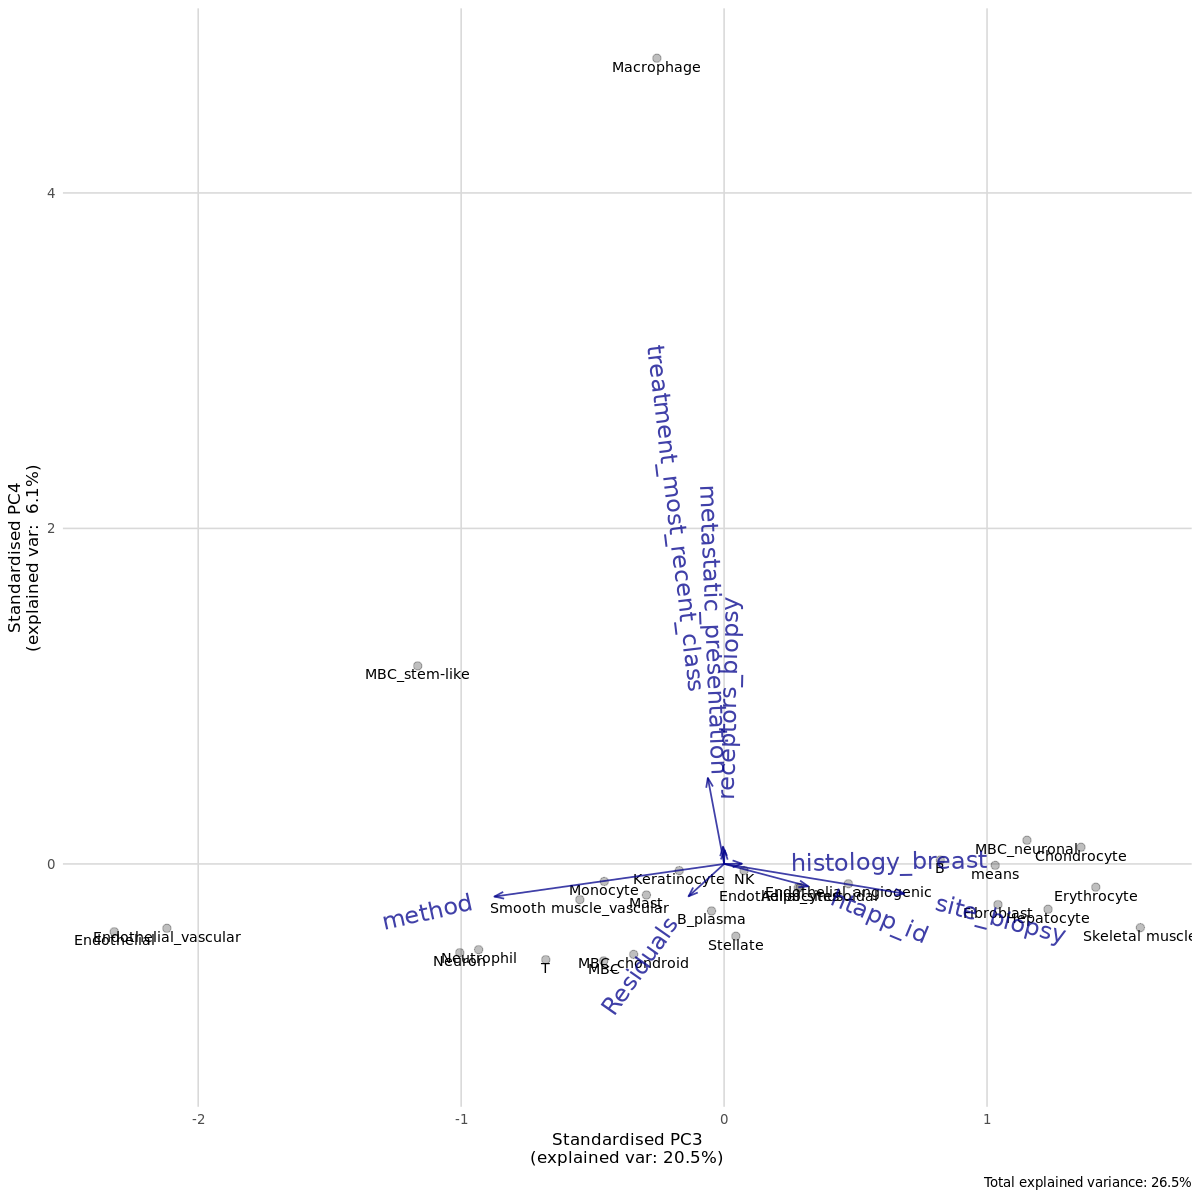

In [24]:
options(repr.plot.width = 10, repr.plot.height =10)
p1=ggplot_pca(pca,choices = c(1,2),arrows_textsize = 5,labels = rownames(varPart_cells))
p2=ggplot_pca(pca,choices = c(3,4),arrows_textsize = 5, labels = rownames(varPart_cells))

pdf("varPart_cells_pca.pdf",width = 10,height = 10)
p1
p2
dev.off()
p1
p2

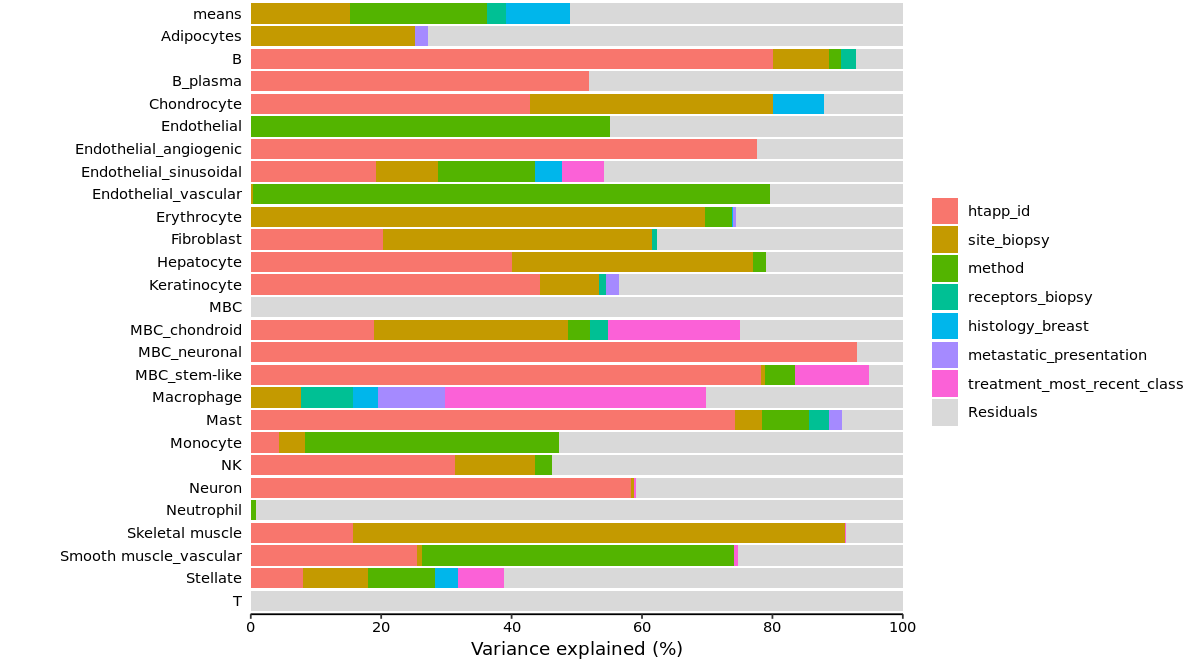

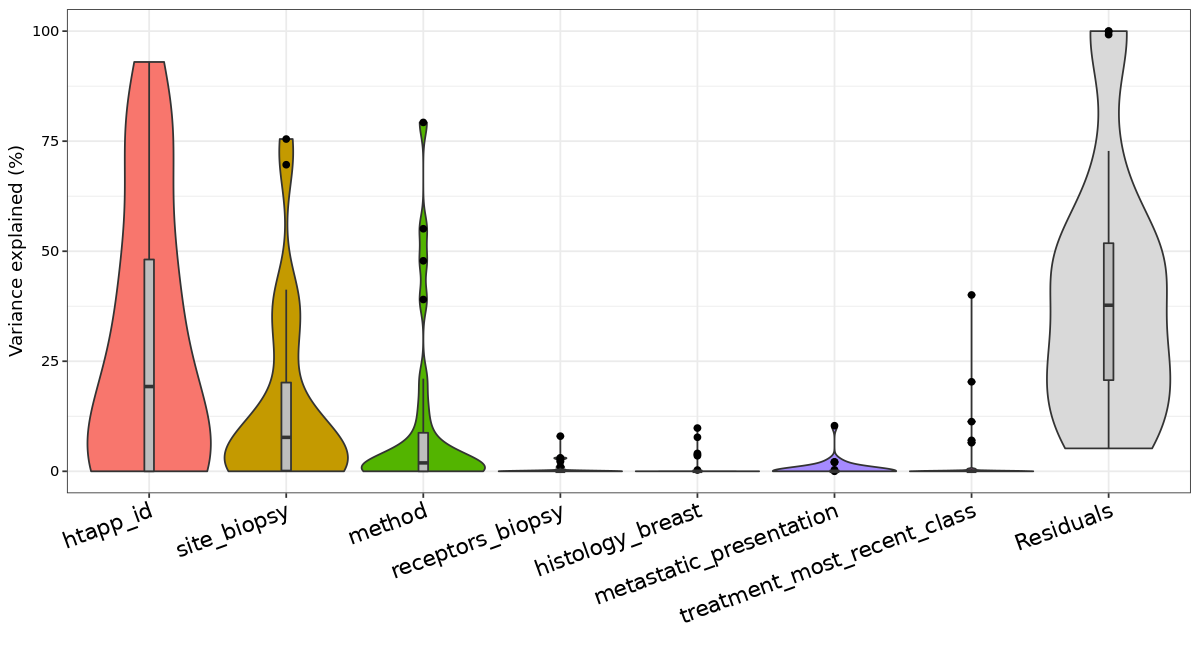

In [54]:
#center log ratio
options(repr.plot.width = 10, repr.plot.height =5.5)
vp_cells <- sortCols( varPart_cells )

plotPercentBars( vp_cells)
plotVarPart( vp_cells )